In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iamsouravbanerjee/animal-image-dataset-90-different-animals")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animal-image-dataset-90-different-animals


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

In [3]:
# Ensuring the GPU is being used
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(f'✅ GPU detected: {physical_devices[0].name}')
else:
    print('⚠️ No GPU found! Training may be slow.')


✅ GPU detected: /physical_device:GPU:0


In [4]:
# Path to the dataset
dataset_path = "/kaggle/input/animal-image-dataset-90-different-animals/animals/animals"

# List all the classes (Animal Types)
try:
    classes = sorted(os.listdir(dataset_path))  # Sorting ensures consistent ordering
    num_classes = len(classes)

    # Display the number of classes along with names
    print(f'✅ Number of Classes: {num_classes}')
    print(f'Classes: {classes}')
except FileNotFoundError:
    print(f'❌ Error: Dataset path not found - {dataset_path}')
except Exception as e:
    print(f'❌ Unexpected error: {e}')


✅ Number of Classes: 90
Classes: ['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar', 'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus', 'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox', 'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon', 'porcupine', 'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros', 'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 'snake', 'sparrow', 'squid', 'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle', 'whale', 'wolf', 'wombat', 'woodpecker', 'zebra']


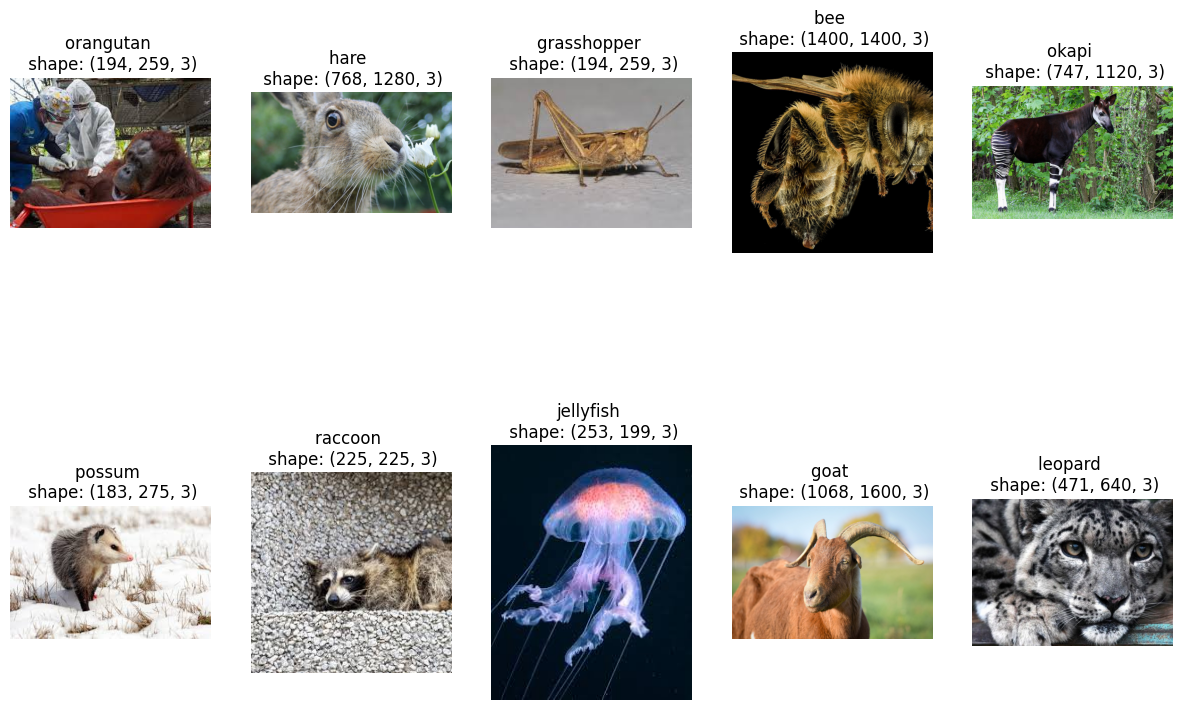

In [5]:
import cv2
import random

# Shuffle classes for diverse visualization
random.shuffle(classes)

# Visualize some sample images from the dataset
plt.figure(figsize=(15, 10))
for i, class_name in enumerate(classes[:10]):
    class_path = os.path.join(dataset_path, class_name)

    try:
        img_name = random.choice(os.listdir(class_path))  # Pick a random image
        img_path = os.path.join(class_path, img_name)

        img = cv2.imread(img_path)  # Read with OpenCV
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.title(f'{class_name} \n shape: {img.shape}')
        plt.axis('off')

    except Exception as e:
        print(f"⚠️ Error loading image from {class_name}: {e}")

plt.show()

In [6]:
# Preprocessing and Augmentation for the dataset

# Image size and batch size
img_size = (224, 224)
batch_size = 64
validation_split = 0.1  # Keep configurable

# Enhanced Data Augmentation for better generalization
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.1,
    fill_mode='nearest',
    validation_split=validation_split
)

# Function to create data generators (train/val)
def create_generator(subset):
    return datagen.flow_from_directory(
        dataset_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset=subset,
        shuffle=True,
        seed=42
    )

# Create generators
train_generator = create_generator('training')
validation_generator = create_generator('validation')

# Sanity check
print(f"Training Samples: {train_generator.samples}")
print(f"Validation Samples: {validation_generator.samples}")


Found 4860 images belonging to 90 classes.
Found 540 images belonging to 90 classes.
Training Samples: 4860
Validation Samples: 540


In [7]:
# Mapping class labels and names
class_indices = train_generator.class_indices

# Sort class names for consistency
class_names = sorted(class_indices, key=lambda x: class_indices[x])

# Display the total number of classes and the mapping
print(f"\nTotal Classes: {len(class_names)}")
print("Class Label Mapping (Name → Index):")
for name in class_names:
    print(f"{name:20s} → {class_indices[name]}")



Total Classes: 90
Class Label Mapping (Name → Index):
antelope             → 0
badger               → 1
bat                  → 2
bear                 → 3
bee                  → 4
beetle               → 5
bison                → 6
boar                 → 7
butterfly            → 8
cat                  → 9
caterpillar          → 10
chimpanzee           → 11
cockroach            → 12
cow                  → 13
coyote               → 14
crab                 → 15
crow                 → 16
deer                 → 17
dog                  → 18
dolphin              → 19
donkey               → 20
dragonfly            → 21
duck                 → 22
eagle                → 23
elephant             → 24
flamingo             → 25
fly                  → 26
fox                  → 27
goat                 → 28
goldfish             → 29
goose                → 30
gorilla              → 31
grasshopper          → 32
hamster              → 33
hare                 → 34
hedgehog             → 35
hippopotamus       

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2

# Constants
IMG_SHAPE = (224, 224, 3)
BASE_LEARNING_RATE = 1e-4
DROPOUT_RATE = 0.5

# Load MobileNetV2 as base model
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SHAPE
)

# Freeze base model for transfer learning
base_model.trainable = False

# Input layer
inputs = Input(shape=IMG_SHAPE)

# Pass input through base model
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(DROPOUT_RATE)(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Final model
model = Model(inputs, outputs)

# Compile
model.compile(
    optimizer=Adam(learning_rate=BASE_LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 90)             │        92,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,661,978 (13.97 MB)

 Trainable params: 1,403,994 (5.36 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
# Training parameters
EPOCHS = 20
STEPS_PER_EPOCH = train_generator.samples // batch_size
VAL_STEPS = validation_generator.samples // batch_size

# Model training
history = model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VAL_STEPS,
    epochs=EPOCHS,
    verbose=1
)


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.0384 - loss: 4.5626 - val_accuracy: 0.4238 - val_loss: 3.4350
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 225ms/step - accuracy: 0.2500 - loss: 3.6344 - val_accuracy: 0.4043 - val_loss: 3.4445
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.3321 - loss: 3.2078 - val_accuracy: 0.6387 - val_loss: 2.2150
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 0.5156 - loss: 2.4137 - val_accuracy: 0.6543 - val_loss: 2.2079
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.5404 - loss: 2.1580 - val_accuracy: 0.7363 - val_loss: 1.4731
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 0.6094 - loss: 1.6158 - val_accuracy: 0.7266 - val_loss: 1.4817
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.6646 - loss: 1.4888 - val_accuracy: 0.7461 - val_loss: 1.1995
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.7344 - loss: 1.1489 - val_accuracy: 0.771

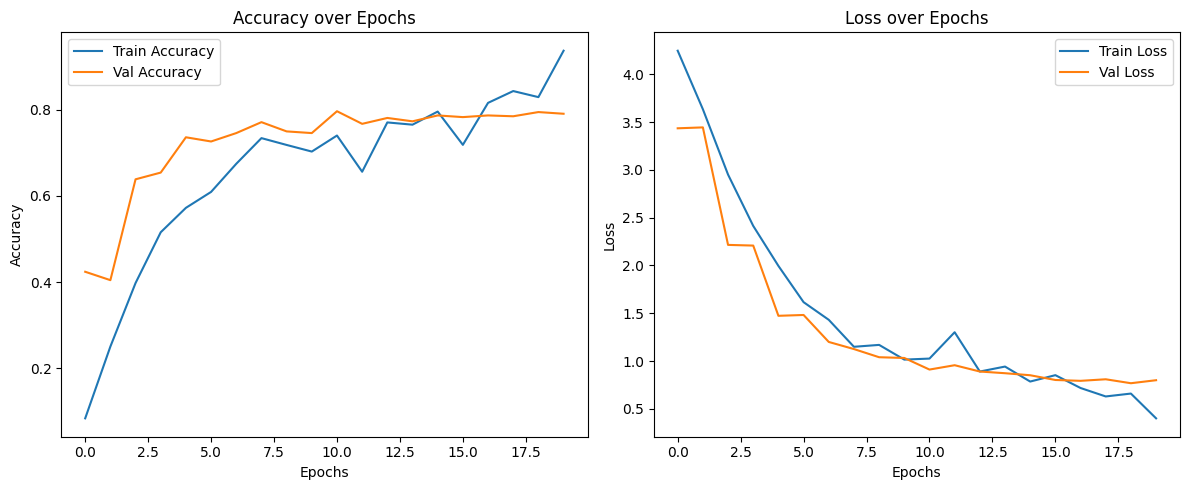

In [13]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function
plot_training_history(history)


In [14]:
def evaluate_model(model, validation_data):
    loss, accuracy = model.evaluate(validation_data, verbose=1)
    print(f"\n✅ Validation Accuracy: {accuracy:.4f}")
    print(f"❌ Validation Loss: {loss:.4f}")
    return loss, accuracy

# Call the function
val_loss, val_accuracy = evaluate_model(model, validation_generator)


9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7879 - loss: 0.8136

✅ Validation Accuracy: 0.7944
❌ Validation Loss: 0.7904


In [15]:
import os

# Define the model save path
model_save_path = "models"
os.makedirs(model_save_path, exist_ok=True)

# Save the model
model_path = os.path.join(model_save_path, 'MCAR.keras')
model.save(model_path)
print(f"✅ Model successfully saved at: {model_path}")


✅ Model successfully saved at: models/MCAR.keras


In [16]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
model_path = "models/MCAR.keras"
model = load_model(model_path)
print(f"✅ Model loaded from: {model_path}")

def predict_animal(img_path):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Predict the class
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions[0])
    predicted_class = class_names[predicted_index]
    confidence = predictions[0][predicted_index]

    # Display results
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class} ({confidence:.2%})")
    plt.axis('off')
    plt.show()


✅ Model loaded from: models/MCAR.keras


In [17]:
import os

# Define the path to a specific animal class (e.g., 'lion')
animal_class = "lion"
animal_class_path = f'/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/{animal_class}'

# List the files in the 'lion' class directory
try:
    animal_files = os.listdir(animal_class_path)
    print(f"Files in {animal_class} class: {animal_files[:5]}...")  # Displaying first 5 files
except FileNotFoundError:
    print(f"❌ The directory for {animal_class} was not found. Please check the path.")


Files in lion class: ['9acdf9a504.jpg', '0a0300a234.jpg', '51d9525bd9.jpg', '1e1b3ea01c.jpg', '4c0f082b74.jpg']...


In [21]:
# List files in the 'lion' class directory to see available images
lion_images = os.listdir(f'/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/lion')

# Display available images
print(lion_images)


['9acdf9a504.jpg', '0a0300a234.jpg', '51d9525bd9.jpg', '1e1b3ea01c.jpg', '4c0f082b74.jpg', '22aa65105f.jpg', '5fb837c61b.jpg', '7cf8e64072.jpg', '4c6ec7185d.jpg', '05d42c9bd8.jpg', '92f5424e4d.jpg', '9b237131a3.jpg', '67e24a4b79.jpg', '35bb50c8cd.jpg', '4c6398221e.jpg', '56b70b4ecc.jpg', '7d8f058238.jpg', '09b23c3373.jpg', '355a292afc.jpg', '49e03e97bf.jpg', '143db76fdf.jpg', '61e6f6109c.jpg', '7dc0036a9d.jpg', '7a9a41f459.jpg', '92c30c59f8.jpg', '48c8d7664f.jpg', '5b8cc93b29.jpg', '33cf8a44c3.jpg', '8b42d2c018.jpg', '70f0d3a1a8.jpg', '65b368f341.jpg', '1e1b33f87e.jpg', '8caaf87eae.jpg', '4d29f849f8.jpg', '3af8eda7af.jpg', '2fac13108c.jpg', '326ccde052.jpg', '25b7a71420.jpg', '0209bbf635.jpg', '35e8b2fceb.jpg', '2d670c088a.jpg', '2e33d2250b.jpg', '9fe4200d49.jpg', '30ec7a1f53.jpg', '96a73103e3.jpg', '8cb1b87044.jpg', '7dcef33a0b.jpg', '4dbdd0fea8.jpg', '0b36ead42d.jpg', '41ee7cdad6.jpg', '8ee9a43ad6.jpg', '5f8df573bf.jpg', '12f57cfa18.jpg', '182efd137c.jpg', '191aede32f.jpg', '26b5f608

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


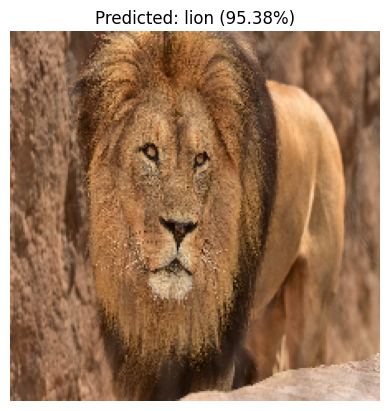

In [22]:
# Specify the image path for the lion class
img_path = f'/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/lion/9acdf9a504.jpg'

# Predict the animal class for the sample image
predict_animal(img_path)
